## Stock Market Prediction using daily news headlines

In [2]:
# If its your first run please install the pandas and plotly

# !pip install pandas_datareader
# !pip install plotly
# !pip install vaderSentiment

**Imports:**

In [3]:
#imports
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from datetime import date, timedelta

#imports sklearn
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import SGDClassifier

In [4]:
# Select your stock and date for analysis.
company_name = 'Facebook'
company_symbol = 'FB'
check_date = "27/08/2014"

In [5]:
# Category dictionary
cat_map={
    'b': 'Business',
    't': 'Science and Technology',
    'e': 'Entertainment',
    'm': 'Health'
}

**Finfiz API which brings us the latest news**

In [6]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

# Finviz url.
url = 'https://finviz.com/quote.ashx?t=' + company_symbol
# Requesting url.
req = Request(url=url, headers={'user-agent':'my-app'})
response = urlopen(req)
# Using BeautifulSoup parsing html code.
html = BeautifulSoup(response, 'html')
# Parsing the table by ID and adding to the dictionary.
news_table = html.find(id='news-table')
# Finding all the table rows.
ocgn_rows = news_table.findAll('tr')

# Empty list.
parsed_data = []
counter = 0
# Getting text from each rows.
for idx, row in enumerate(ocgn_rows):
    title = row.a.text
    publisher = row.span.text
    date_data = row.td.text.split(' ')
    if len(date_data) == 1:
            hour = date_data[0][0:7]
    else:
        date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%d/%m/%Y')
        hour = date_data[1][0:7]
    # Adding title into parsed_data list.
    parsed_data.append([counter, title, date, hour, publisher])
    counter += 1
    
# Creating data frame using parsed_data (Today's Last 100 news).
today_df = pd.DataFrame(parsed_data, columns=['ID', 'Title', 'Date', 'Time', 'Publisher'])
today_dominant_publisher = today_df['Publisher'].mode().values[-1]

In [7]:
# Reading the data from CSV.
data = pd.read_csv('uci-news-aggregator.csv')

In [8]:
# Print count of each value before the cleaning.
print("Empty values in each column:")
data.isnull().sum()

Empty values in each column:


ID           0
TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

## cleaning the dateset:

In [9]:
# Drop selected features.
def drop_features(data,features):
    return data.drop(features, axis=1)

In [10]:
# Filling the empty value column with 'U' (Unknown).
def filling_empty_value_in_unknown_val(data,value):
    data[value].fillna('U', inplace=True)
    return data

In [11]:
# Clean the data and drops all the not important values.
features = ['URL', 'STORY','HOSTNAME'] 
data=drop_features(data,features)
data=filling_empty_value_in_unknown_val(data,'PUBLISHER')

In [12]:
#Print count of each value after the cleaning.
print("Empty values in each column after the cleaning:")
data.isnull().sum()

Empty values in each column after the cleaning:


ID           0
TITLE        0
PUBLISHER    0
CATEGORY     0
TIMESTAMP    0
dtype: int64

In [13]:
data.head()

,ID,TITLE,PUBLISHER,CATEGORY,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",Los Angeles Times,b,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,Livemint,b,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,IFA Magazine,b,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",IFA Magazine,b,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Moneynews,b,1394470372027


In [14]:
# Creates pie chart by columns names.
def create_pie_chart_of_count(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    fig = px.pie(df_not_null.groupby([column_name]).size().reset_index(name='count'), names=column_name, values='count')
    fig.show()

## Pie chart of all the catrgorys in dataset:

In [ ]:
#Show all the news of the dataset by category.
create_pie_chart_of_count(data, 'CATEGORY')

In [15]:
# Convert timestamp to datetime.
def timestamp_to_date(ts):
    s = ts / 1000.0
    date = datetime.datetime.fromtimestamp(s).strftime('%d/%m/%Y')
    return date

In [16]:
# Function that gets the text and removes all punctuation.
def remove_punctuation(text):
    rdd = sc.parallelize(text)
        
    news_rdd = rdd.map(lambda word: word.replace("-"," "))\
        .map(lambda word: word.replace(",",""))\
        .map(lambda word: word.replace(".",""))\
        .map(lambda word: word.replace(";",""))\
        .map(lambda word: word.replace("”",""))\
        .map(lambda word: word.replace('"',""))\
        .map(lambda word: word.replace("[",""))\
        .map(lambda word: word.replace("]",""))\
        .map(lambda word: word.replace("?",""))\
        .map(lambda word: word.replace("/",""))\
        .map(lambda word: word.replace("$",""))\
        .map(lambda word: word.replace("/",""))\
        .map(lambda word: word.replace("'",""))\
        .map(lambda word: word.replace(")",""))\
        .map(lambda word: word.replace("(",""))\
        .map(lambda word: word.replace(":",""))
        
    return news_rdd.collect()

In [17]:
# Function that returns about 100 articles by a particular company before the selected date.
def hundred_news_before_date(df, date, company_name):
    timestamp = int(time.mktime(datetime.datetime.strptime(date, "%d/%m/%Y").timetuple()))*1000
    comp_df = df[df['TITLE'].str.lower().str.contains(company_name.lower())]
    new_df = comp_df[comp_df['TIMESTAMP'] < timestamp]
    
    return new_df.tail(100)
    
company_news_df = hundred_news_before_date(data, check_date, company_name)
company_news_df

,ID,TITLE,PUBLISHER,CATEGORY,TIMESTAMP
407106,407625,Facebook's 'Internet.org' Effort Reaches Africa,Design \& Trend,t,1406868286342
407107,407626,Facebook Launches Internet.org App in Zambia,AFKInsider,t,1406868286558
407108,407627,"Facebook unveils free Net app, starting in Zambia",Gulf Today,t,1406868287385
407109,407628,Facebook Debuts App For Free Web Access In Eme...,MediaPost Communications,t,1406868287986
407110,407629,Facebook launches free internet app for basic ...,Zee News,t,1406868288262
...,...,...,...,...,...
416011,416530,Fugitive 'who violated his parole' is captured...,Daily Mail,e,1409029095025
416047,416566,Fugitive Arrested After Posting Facebook Video...,Headlines \& Global News,e,1409029107770
416155,416674,Facebook user claims that only 7% of ALS chall...,Daily News \& Analysis,e,1409029144538
416184,416703,#InTheNews: Criminal Who Posted A Video Of His...,360Nobs.com,e,1409029154255


In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Function that sentiment of the title.
def sent_analysis(title):
    sid_obj= SentimentIntensityAnalyzer()
    return sid_obj.polarity_scores(title)


In [19]:
# An example of the sentiment about 100 titles that we received in "hundred_news_before_date" func.
sen = sent_analysis(str(remove_punctuation(company_news_df['TITLE'].str.lower())))
del sen['compound']
sen

{'neg': 0.081, 'neu': 0.807, 'pos': 0.112}

([<matplotlib.patches.Wedge at 0x7fdcf59e4550>,
 [Text(-0.2794220198266637, 1.0742547811557497, 'neg'),
  Text(-0.10793146114127224, -1.1047401503049983, 'neu'),
  Text(0.3825537535990802, 1.0419945420237355, 'pos')])

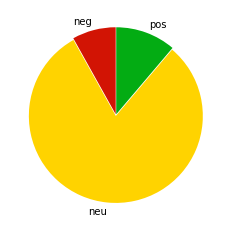

In [20]:
colors = ['#d21404','#ffd300','#03ac13']
plt.pie(list(sen.values()),labels=sen.keys(),explode=(0.01, 0.01, 0.01),startangle=90,colors=colors)

In [21]:
# Functions that prints.
def category_graph_countplot(df):
    ax=sns.countplot(x=df)
    ax.set_title("Category Counts")
    ax.set_xlabel("Category")
    ax.set_xticklabels([cat_map[l.get_text()] for l in ax.get_xticklabels()])
    plt.show()

In [ ]:
# Show all the categorys of 100 first titles.
category_graph_countplot(company_news_df['CATEGORY'])

In [22]:
 # Creates columns bar by columns names.
def create_bar_of_count(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    fig = px.bar(df_not_null.groupby([column_name]).size().reset_index(name='count'), x=column_name, y='count')
    fig.show()

In [ ]:
# Shows all the publishers of a 100 news
create_bar_of_count(company_news_df, 'PUBLISHER')

In [23]:
# The functions gets a date and returns if the stock went up or down one month later.
# False means DOWN and True means UP.
# Date input veriation dd/mm/yyyy.
def up_down_by_date(symbol, start_date):
    start = datetime.datetime.strptime(start_date, "%d/%m/%Y")
    end = start + timedelta(days=30)
    first = pdr.get_data_yahoo(symbols=symbol, start = start, end = end)
    x = float(first.tail(1)['Close']) - float(first.head(1)['Close'])
    return x > 0

up_down = up_down_by_date(company_symbol, check_date)
if up_down is True:
    print('Stock went UP')
else:
    print('Stock went DOWN')

Stock went UP


In [24]:
# Initialize list of lists.
first_row = [[80, check_date, sen['neg'], sen['neu'], sen['pos'], company_news_df['PUBLISHER'].mode().values[-1], company_news_df['CATEGORY'].mode().values[-1], up_down]]
 
# Create the pandas DataFrame with the sentiment, up or down and the dominated publisher and category.
df = pd.DataFrame(first_row, columns = ['ID','Date', 'Neg', 'Neu','Pos', 'DPublisher', 'DCategory', 'Up'])

### Print one row from a 100 news.
- Neg - Negative.
- Neu - Neutral.
- Pos - Positive.
- DPublisher - Dominant Publisher.
- DCategory - Dominant Category.
- Up - 1 is up, 0 is down, one month after the date in which we took the last hundred news.
  

In [25]:
df

,ID,Date,Neg,Neu,Pos,DPublisher,DCategory,Up
0,80,27/08/2014,0.081,0.807,0.112,Wall Street Journal \(blog\),t,True


In [26]:
# Function return about 160 dates in jumps of two days back frome the slected date.
last_date = check_date
def make_date():
    global last_date
    last_date = datetime.datetime.strptime(last_date, "%d/%m/%Y") - timedelta(days=2)
    last_date = last_date.strftime("%d/%m/%Y")
    return last_date

dates = [make_date() for i in range(80)]

- So untill now we showed and example which shows how we got our first row in the dataframe now we'll load 100 rows more.

- In the next cell we are going to make the dataframe for the machine learning in a parallel by spark.

In [27]:
rdd_dates = spark.sparkContext.parallelize(dates)
id_rdd = spark.sparkContext.parallelize(range(80))
rdd_up_down = rdd_dates.map(lambda x: up_down_by_date(company_symbol, x))

rdd_pub = rdd_dates.map(lambda x: hundred_news_before_date(data, x, company_name)['PUBLISHER'].mode().values[-1])
rdd_cat = rdd_dates.map(lambda x: hundred_news_before_date(data, x, company_name)['CATEGORY'].mode().values[-1])

rdd_news = rdd_dates.map(lambda x: list(hundred_news_before_date(data, x, company_name)['TITLE'].str.lower()))

rdd_sentiments = rdd_news.map(lambda x: sent_analysis(str(x)))
rdd_sentiments = rdd_sentiments.map(lambda x: [x['neg'],x['neu'],x['pos']])

In [28]:
from pyspark.sql.types import StringType, FloatType, BooleanType, IntegerType

id_df = spark.createDataFrame(id_rdd, IntegerType()).toDF("ID").toPandas()
dates_df = spark.createDataFrame(rdd_dates, StringType()).toDF("Date").toPandas()
up_down_df = spark.createDataFrame(rdd_up_down, BooleanType()).toDF("Up").toPandas()
sent_df = spark.createDataFrame(rdd_sentiments).toDF('Neg','Neu','Pos').toPandas()
pub_df =  spark.createDataFrame(rdd_pub, StringType()).toDF("DPublisher").toPandas()
cat_df =  spark.createDataFrame(rdd_cat, StringType()).toDF("DCategory").toPandas()

new_df = pd.concat([id_df,dates_df,sent_df,pub_df,cat_df, up_down_df], axis=1)

In [29]:
new_df.head()

,ID,Date,Neg,Neu,Pos,DPublisher,DCategory,Up
0,0,25/08/2014,0.019,0.833,0.149,The Independent,t,True
1,1,23/08/2014,0.019,0.833,0.149,The Independent,t,True
2,2,21/08/2014,0.019,0.833,0.149,The Independent,t,True
3,3,19/08/2014,0.019,0.833,0.149,The Independent,t,True
4,4,17/08/2014,0.019,0.833,0.149,The Independent,t,True


In [30]:
new_df.loc[80] = df.values.tolist()[0]
df = new_df
df

,ID,Date,Neg,Neu,Pos,DPublisher,DCategory,Up
0,0,25/08/2014,0.019,0.833,0.149,The Independent,t,True
1,1,23/08/2014,0.019,0.833,0.149,The Independent,t,True
2,2,21/08/2014,0.019,0.833,0.149,The Independent,t,True
3,3,19/08/2014,0.019,0.833,0.149,The Independent,t,True
4,4,17/08/2014,0.019,0.833,0.149,The Independent,t,True
...,...,...,...,...,...,...,...,...
76,76,26/03/2014,0.115,0.797,0.089,Times of India,t,False
77,77,24/03/2014,0.107,0.781,0.111,ValueWalk,t,False
78,78,22/03/2014,0.083,0.797,0.120,ValueWalk,t,False
79,79,20/03/2014,0.085,0.797,0.118,ValueWalk,t,False


compare up vs down in the DataFrame:


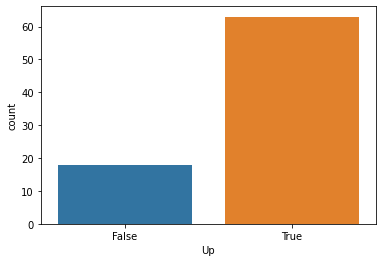

In [31]:
# Graph that compare up vs down in the DataFrame.
print('compare up vs down in the DataFrame:')
sns.countplot(x='Up', data=df)
plt.show()

In [ ]:
# Graph that print the count of all the positive movement stock by the Publisher.
print('Positive DataFrame:')
up_df = df[df['Up'] == True]
create_bar_of_count(up_df, 'DPublisher')


In [ ]:
# Graph that print the count of all the negative movement stock by the Publisher.
print('Negative DataFrame:')
down_df = df[df['Up'] == False]
create_bar_of_count(down_df, 'DPublisher')

In [32]:
# Function that prints a heat map of all the features.
def graph_heatmap(data):
    plt.figure(figsize=(9,6))
    cor = np.abs(data.corr())
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, vmin=-1, vmax=1)
    plt.show()

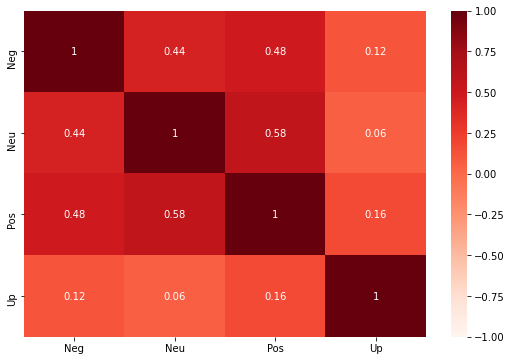

In [33]:
# Show heatmap graph.
graph_heatmap(df.drop('ID', axis=1))

#  Creation hypers:

In [34]:
# Function that checking if have a direct relationship between the cognitive and the movement of the stock.
def check_connection_between_sentiment_up(data):
     if ((data['Pos'] > data['Neg']) and data['Up'] == 1) or ((data['Pos'] < data['Neg']) and data['Up'] == 0):
        return 1
     else:
        return 0

# Activation of the hypers.    
def apply_hypers(data):
    data['Cbetween_sentiment_up'] = data.apply(check_connection_between_sentiment_up, axis = 1)

apply_hypers(df)
df

,ID,Date,Neg,Neu,Pos,DPublisher,DCategory,Up,Cbetween_sentiment_up
0,0,25/08/2014,0.019,0.833,0.149,The Independent,t,True,1
1,1,23/08/2014,0.019,0.833,0.149,The Independent,t,True,1
2,2,21/08/2014,0.019,0.833,0.149,The Independent,t,True,1
3,3,19/08/2014,0.019,0.833,0.149,The Independent,t,True,1
4,4,17/08/2014,0.019,0.833,0.149,The Independent,t,True,1
...,...,...,...,...,...,...,...,...,...
76,76,26/03/2014,0.115,0.797,0.089,Times of India,t,False,1
77,77,24/03/2014,0.107,0.781,0.111,ValueWalk,t,False,0
78,78,22/03/2014,0.083,0.797,0.120,ValueWalk,t,False,0
79,79,20/03/2014,0.085,0.797,0.118,ValueWalk,t,False,0


## we can clearly see the connection between cognition and stock movement.

In [ ]:
# Graph that depicthing the relationship between cognition and displacement.
create_pie_chart_of_count(df, 'Cbetween_sentiment_up')

In [35]:
# Encoding all the values and preparing for the ml process.
def one_hot_enc(df):
    dumC = pd.get_dummies(df.DCategory)
    dumP = pd.get_dummies(df.DPublisher)
    df = pd.concat([df, dumC], axis='columns')
    df = pd.concat([df, dumP], axis='columns')
    new_df=drop_features(df,['DPublisher','DCategory'])
    return new_df

# Add a new publisher from the articles of the current date.
counter = len(df)
cat_lst = set(['b','t','e','m'])
cat_lst = cat_lst - set(df['DCategory'])
for item in list(cat_lst):
    df.loc[counter] = [100,check_date, 1, 1, 1, today_dominant_publisher, item, True,1]
    counter += 1

In [36]:
# Activation the encoding. 
new_df = one_hot_enc(df)

# Delething the new publisher before sending to ml.
for i in range(len(cat_lst)):
    new_df = new_df.drop(new_df[new_df.ID == 100].index)
new_df

,ID,Date,Neg,Neu,Pos,Up,Cbetween_sentiment_up,b,e,m,...,The FA Daily,The Independent,The Next Web,Times of India,Ubergizmo,ValueWalk,WKRB News,Wall Street Journal \(blog\),Washington Post \(blog\),gamrReview
0,0,25/08/2014,0.019,0.833,0.149,True,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,23/08/2014,0.019,0.833,0.149,True,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,21/08/2014,0.019,0.833,0.149,True,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3,19/08/2014,0.019,0.833,0.149,True,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,4,17/08/2014,0.019,0.833,0.149,True,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,26/03/2014,0.115,0.797,0.089,False,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
77,77,24/03/2014,0.107,0.781,0.111,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
78,78,22/03/2014,0.083,0.797,0.120,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
79,79,20/03/2014,0.085,0.797,0.118,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [37]:
# Split the train and the test.
train_df, test_df = train_test_split(new_df, test_size=0.35, random_state=42)

In [38]:
# Show the train_df.
train_df

,ID,Date,Neg,Neu,Pos,Up,Cbetween_sentiment_up,b,e,m,...,The FA Daily,The Independent,The Next Web,Times of India,Ubergizmo,ValueWalk,WKRB News,Wall Street Journal \(blog\),Washington Post \(blog\),gamrReview
39,39,08/06/2014,0.054,0.833,0.114,False,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
56,56,05/05/2014,0.043,0.783,0.174,True,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80,80,27/08/2014,0.081,0.807,0.112,True,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,7,11/08/2014,0.019,0.833,0.149,True,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
50,50,17/05/2014,0.136,0.817,0.048,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,53,11/05/2014,0.097,0.785,0.118,True,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19,19,18/07/2014,0.162,0.761,0.077,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,66,15/04/2014,0.055,0.847,0.099,False,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
25,25,06/07/2014,0.113,0.836,0.050,True,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
44,44,29/05/2014,0.085,0.888,0.027,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Split independant and dependanat features.
X = train_df.drop(['Up', 'Date'], axis=1)
y = train_df['Up']

In [40]:
# Split the train and the test for ml.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

## Predictive models:

In [41]:
# Logistic Regression.
lr = LogisticRegression(random_state=42, solver="liblinear")
lr.fit(X_train, y_train)
lr_predict = lr.predict(test_df.drop(['Up','Date'], axis=1))

## Prints the  accuracy of the models:

In [42]:
accuracy = accuracy_score(test_df['Up'], lr_predict)
print('LR accuracy - ', accuracy)

LR accuracy -  0.9310344827586207


In [43]:
# Try model on test dataset.
predict_test = lr_predict

In [44]:
# Show the prediction.
comparing_df = test_df.loc[:, test_df.columns.intersection(['ID','Date','Up'])]
comparing_df.insert(3, 'Prediction', predict_test)
comparing_df

,ID,Date,Up,Prediction
30,30,26/06/2014,True,True
0,0,25/08/2014,True,True
22,22,12/07/2014,True,True
31,31,24/06/2014,True,True
18,18,20/07/2014,True,True
28,28,30/06/2014,True,True
10,10,05/08/2014,True,True
70,70,07/04/2014,True,True
4,4,17/08/2014,True,True
12,12,01/08/2014,True,True


In [45]:
# Print data of the prediction.
from sklearn.metrics import classification_report
eval_report = classification_report(test_df['Up'], predict_test, target_names=['0: Down', '1: Up'], output_dict=True)

edf = pd.DataFrame(eval_report).T
edf

,precision,recall,f1-score,support
0: Down,1.000000,0.600000,0.750000,5.000000
1: Up,0.923077,1.000000,0.960000,24.000000
accuracy,0.931034,0.931034,0.931034,0.931034
macro avg,0.961538,0.800000,0.855000,29.000000
weighted avg,0.936340,0.931034,0.923793,29.000000


In [46]:
# Creating data frame using parsed_data (Last 100 news).
df1 = pd.DataFrame(parsed_data, columns=['ID', 'Title', 'Date', 'Time', 'Publisher'])
df1.insert(3, 'Category', 't')

def update_category(df, word):
    df.loc[(df['Title'].str.lower().str.contains(word)), 'Category'] = "b"
    return df

words = ['buy', 'sell', 'deal', 'sale', 'dollar', 'cash', 'rich', 'business', 'market', 'stock']

for w in words:
    df1 = update_category(df1, w)
    
# Displaying data frame.
df1.head(20)

,ID,Title,Date,Category,Time,Publisher
0,0,Online Ad Revenue Growth Slowed By Ukraine War...,29/03/2022,t,04:26PM,Barrons.com
1,1,Stocks end the day in the green as investors e...,29/03/2022,b,04:10PM,Yahoo Finance Video
2,2,These Are The 5 Best Stocks To Buy And Watch Now,29/03/2022,b,02:09PM,Investor's Business Daily
3,3,Facebook owner Meta puts plans to build Dutch ...,29/03/2022,t,01:02PM,Reuters
4,4,Facebook owner Meta puts plans to build Dutch ...,29/03/2022,t,12:57PM,Reuters
5,5,"Warren Buffett Stocks: Alphabet, Microsoft Amo...",29/03/2022,b,11:45AM,Investor's Business Daily
6,6,Meta Halts Plans for Large Dutch Data Center o...,29/03/2022,t,11:04AM,Bloomberg
7,7,Justice Department backs Big Tech antitrust bi...,29/03/2022,t,09:29AM,Yahoo Finance Video
8,8,Morgan Stanley Downgrades Pinterest Amid Chall...,29/03/2022,t,09:17AM,Benzinga
9,9,Civil society must be part of the Digital Serv...,29/03/2022,t,09:01AM,Financial Times


In [47]:
# Processing the latest articels.
import time
sentiment = sent_analysis(str(remove_punctuation(df1['Title'].str.lower())))

# Initialize list of lists.
today = datetime.datetime.today().strftime('%d/%m/%Y')
data1 = [[0, today, sentiment['neg'],sentiment['neu'],sentiment['pos'], df1['Publisher'].mode().values[-1], df1['Category'].mode().values[-1]]]
 
# Create the pandas DataFrame with the sentiment, up or down and the dominated publisher and category.
df_final = pd.DataFrame(data1, columns = ['ID','Date', 'Neg','Neu','Pos', 'DPublisher', 'DCategory'])
df_final

,ID,Date,Neg,Neu,Pos,DPublisher,DCategory
0,0,30/03/2022,0.102,0.809,0.089,Bloomberg,t


In [48]:
# Encoding the latest articles.
publisher = df_final.DPublisher[0].lstrip()
prediction_val = new_df[new_df[publisher] == 1].head(1).drop(['Up','Date'], axis=1)
prediction_val['Neg'], prediction_val['Neu'], prediction_val['Pos'] = sentiment['neg'],sentiment['neu'],sentiment['pos']
prediction_val['ID'] = 101

prediction_val

,ID,Neg,Neu,Pos,Cbetween_sentiment_up,b,e,m,t,Bloomberg,...,The FA Daily,The Independent,The Next Web,Times of India,Ubergizmo,ValueWalk,WKRB News,Wall Street Journal \(blog\),Washington Post \(blog\),gamrReview
74,101,0.102,0.809,0.089,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Final prediction of rise or fall by the current date.
# Up = True Down = False.
final_prediction = lr.predict(prediction_val)
if final_prediction[0]:
    print(company_name, 'will go UP month from now')
else:
    print(company_name, 'will go DOWN month from now')

Facebook will go DOWN month from now


#### Sources:

400K news CSV File:
https://www.kaggle.com/uciml/news-aggregator-dataset